In [1]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Λήψη δεδομένων
symbol = 'AMZN'
start_date = '2018-11-30'
end_date = '2023-11-30'
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Καθαρισμός και επεξεργασία δεδομένων
df.dropna(inplace=True)
df['Return'] = df['Close'].pct_change()
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# Συνάρτηση για υπολογισμό RSI
def calculate_rsi(data, column_name, period=14):
    delta = data[column_name].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [5]:
# Συνάρτηση για υπολογισμό MACD
def calculate_macd(data, column_name, short_window=12, long_window=26, signal_window=9):
    short_ema = data[column_name].ewm(span=short_window, adjust=False).mean()
    long_ema = data[column_name].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(
        span=signal_window, adjust=False).mean()
    return data

In [6]:
# Συνάρτηση για υπολογισμό Bollinger Bands
def calculate_bollinger_bands(data, column_name, window=20, num_std=2):
    data['Rolling_Mean'] = data[column_name].rolling(
        window=window, min_periods=1).mean()
    data['Upper_Band'] = data['Rolling_Mean'] + \
        (data[column_name].rolling(window=window, min_periods=1).std() * num_std)
    data['Lower_Band'] = data['Rolling_Mean'] - \
        (data[column_name].rolling(window=window, min_periods=1).std() * num_std)
    return data

In [7]:
# Προσθήκη δεικτών RSI, MACD και Bollinger Bands
df['RSI'] = calculate_rsi(df, 'Close')
df = calculate_macd(df, 'Close')
df = calculate_bollinger_bands(df, 'Close')

In [8]:
# Δημιουργία μεταβλητών για το μοντέλο μηχανικής μάθησης
df['Previous_Close'] = df['Close'].shift(1)
df.dropna(inplace=True)

In [9]:
# Διαχωρισμός σε σετ εκπαίδευσης και δοκιμής
X = df[['Date', 'Previous_Close']]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False)

In [10]:
# Εκπαίδευση μοντέλου
model = DecisionTreeRegressor()
model.fit(X_train.drop('Date', axis=1), y_train)

DecisionTreeRegressor()

In [11]:
# Πρόβλεψη τιμών
predictions = model.predict(X_test.drop('Date', axis=1))

In [12]:
# Αξιολόγηση μοντέλου
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 17.033557350343067


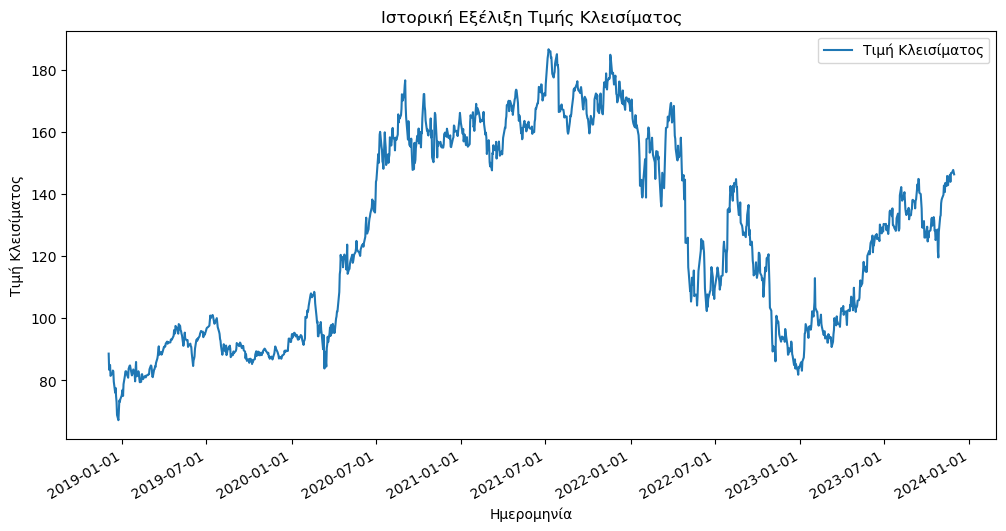

In [13]:
# Σχεδίαση ιστορικής εξέλιξης τιμής, δεικτών και προβλεπόμενων τιμών
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Τιμή Κλεισίματος')
plt.title('Ιστορική Εξέλιξη Τιμής Κλεισίματος')
plt.xlabel('Ημερομηνία')
plt.ylabel('Τιμή Κλεισίματος')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
plt.show()

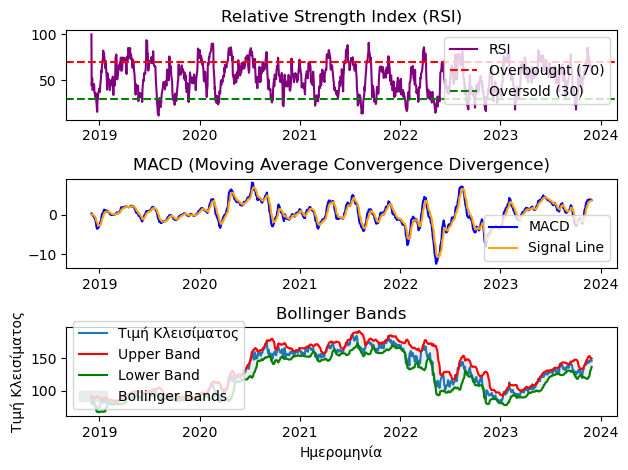

In [14]:
# RSI
plt.subplot(3, 1, 1)
plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.legend()

# MACD
plt.subplot(3, 1, 2)
plt.plot(df['Date'], df['MACD'], label='MACD', color='blue')
plt.plot(df['Date'], df['Signal_Line'], label='Signal Line', color='orange')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.legend()

# Bollinger Bands
plt.subplot(3, 1, 3)
plt.plot(df['Date'], df['Close'], label='Τιμή Κλεισίματος')
plt.plot(df['Date'], df['Upper_Band'], label='Upper Band', color='red')
plt.plot(df['Date'], df['Lower_Band'], label='Lower Band', color='green')
plt.fill_between(df['Date'], df['Upper_Band'], df['Lower_Band'],
                 color='lightgray', alpha=0.4, label='Bollinger Bands')
plt.title('Bollinger Bands')
plt.xlabel('Ημερομηνία')
plt.ylabel('Τιμή Κλεισίματος')
plt.legend()

plt.tight_layout()
plt.show()

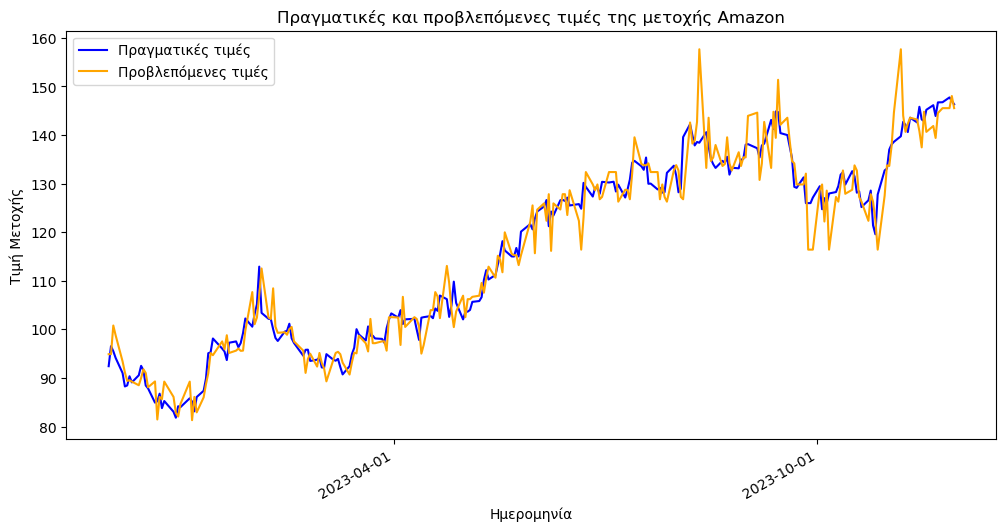

In [15]:
# Εμφάνιση πραγματικών και προβλεπόμενων τιμών
plt.figure(figsize=(12, 6))
plt.plot(X_test['Date'], y_test, color='blue', label='Πραγματικές τιμές')
plt.plot(X_test['Date'], predictions,
         color='orange', label='Προβλεπόμενες τιμές')
plt.title('Πραγματικές και προβλεπόμενες τιμές της μετοχής Amazon')
plt.xlabel('Ημερομηνία')
plt.ylabel('Τιμή Μετοχής')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

plt.show()